<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description-and-Dataset" data-toc-modified-id="Description-and-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description and Dataset</a></span></li><li><span><a href="#Method:-Expected-Signature" data-toc-modified-id="Method:-Expected-Signature-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Method: Expected Signature</a></span></li><li><span><a href="#Method:-Pathwise-expected-signature" data-toc-modified-id="Method:-Pathwise-expected-signature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method: Pathwise expected signature</a></span></li><li><span><a href="#Method:-RBF-kernel-mean-embedding" data-toc-modified-id="Method:-RBF-kernel-mean-embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Method: RBF kernel mean embedding</a></span></li><li><span><a href="#Comments" data-toc-modified-id="Comments-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comments</a></span></li></ul></div>

In [49]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import iisignature
import sys
sys.path.append("Distribution_Regression_Streams/")
from importlib import reload
import GP_models.GP_sig_precomputed as GP_sig
import GP_models.GP_classic as GP_classic
from data_generators import SDE
import signature_features
import utils
import experiments

# Description and Dataset

We apply different models to the problem of statistical inference for SDEs. From a set of samples from a parametrized family of stochastic processes, we want to infer the parameter.

The example considered in this notebook is the following

\begin{align*}
dY_t = dW^{1}_t + (1+\sqrt{\theta})dW^2_t
\end{align*}

We observe independent copies of $\{Y_t,t\in[0,T]\}$ and we want to infer $\theta$

In [25]:
reload(SDE)

t_span=np.linspace(0,10,100)
spec_param={'theta_1':[0,0.5],'Y0':[0.,0.]}

example = SDE.sde(N_bags=75,N_items=15,t_span=t_span,spec_param=spec_param)

# generate data and get the labels
example.generate_data()
example.get_param()

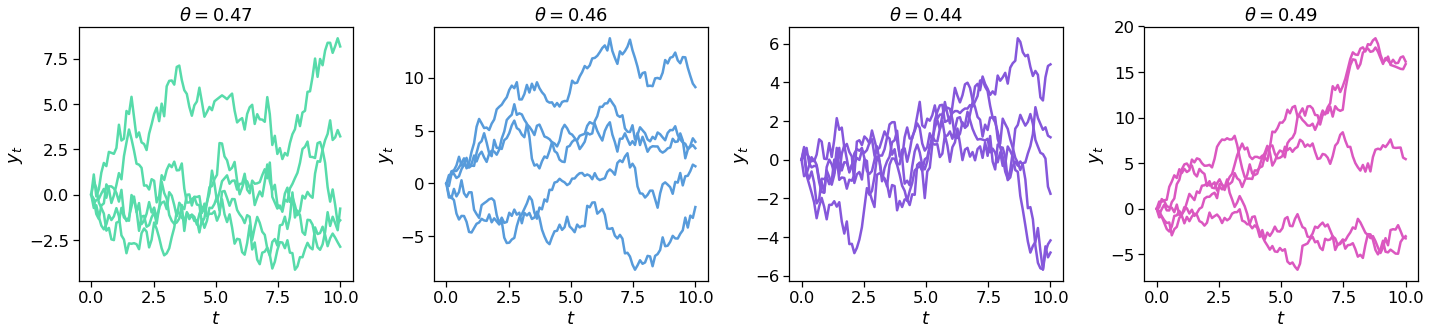

In [26]:
example.plot()

Choose whether to standard scale the data or not, and obtain a train/test split

In [27]:
reload(utils)
data_scaled, y_scaled, train_indices, test_indices = utils.split_standardize(example.labels,example.paths,standardized=False,method='standard')

As the paths $y$ are one dimensional, we add 

In [28]:
X_aug = utils.add_dimension(data_scaled,add_time=False,lead_lag=0)

# Method: Expected Signature

\begin{align*}
K_1(\mu,\nu)=\exp{\Bigl(-\frac{\|\mathbb{E}_{X\sim\mu}[S(X)]-\mathbb{E}_{Y\sim\nu}[S(Y)]\|^2}{2\ell^2}\Bigr)}
\end{align*}

shape of the final features (N_bags, D): (75, 30)


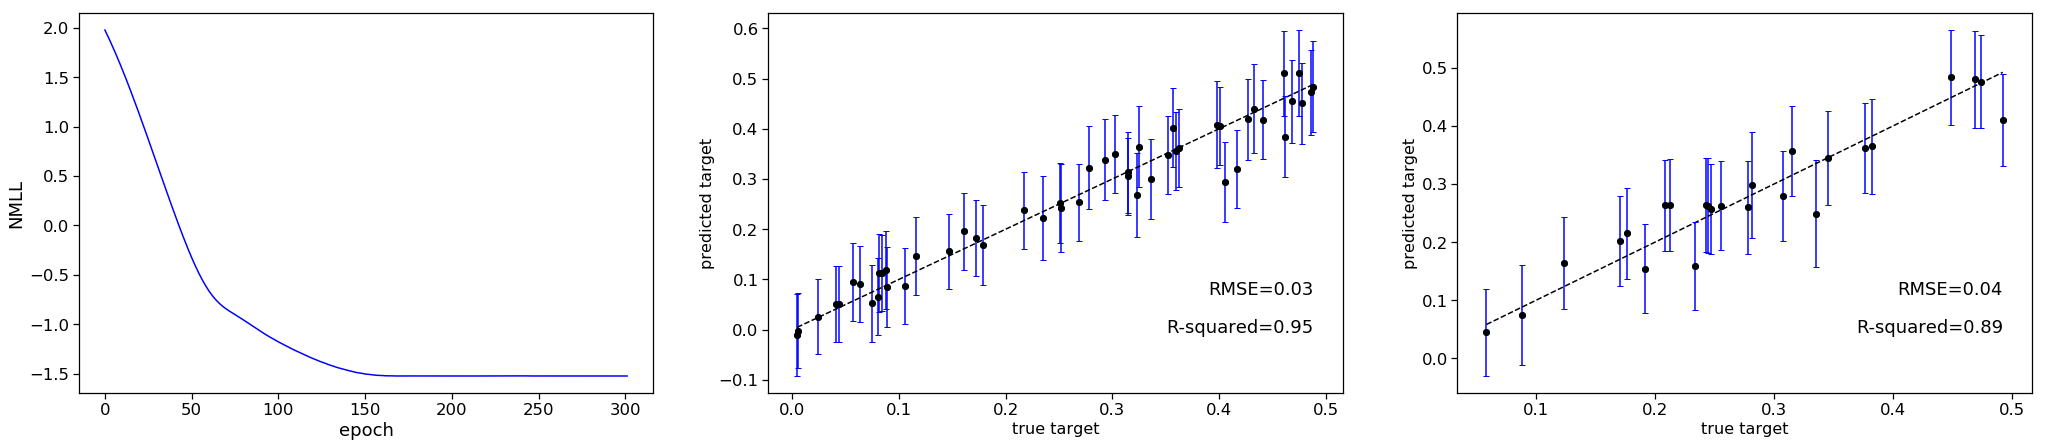

In [48]:
reload(experiments)
reload(signature_features)
reload(GP_sig)

sig_level = 4

# Compute the expected signature
expected_sig = signature_features.scaled_expected_sig([e.copy() for e in X_aug],sig_level)

# Standard scale the features
features = expected_sig

## potentially scale the features
# scaler = StandardScaler()
# to_fit = [features[i] for i in train_indices]
# scaler.fit(to_fit)
# features = scaler.transform(features)

print('shape of the final features (N_bags, D):', features.shape)

# Precompute the Gram matrix, as we do not optimize any parameter
K_precomputed = experiments.precompute_K(features)

# Train and Predict
experiments.experiment_precomputed(K_precomputed,y_scaled,train_indices,test_indices,RBF=False,plot=True)
      

# Method: Pathwise expected signature

\begin{align*}
K_2(\mu,\nu)=\langle S(\gamma^{\mu}), S(\gamma^{\nu})\rangle && \gamma^{\mu}=t\mapsto\mathbb{E}_{X\sim\mu}S(X|_{0,t})
\end{align*}

shape of the final features (N_bags, D): (75, 30)


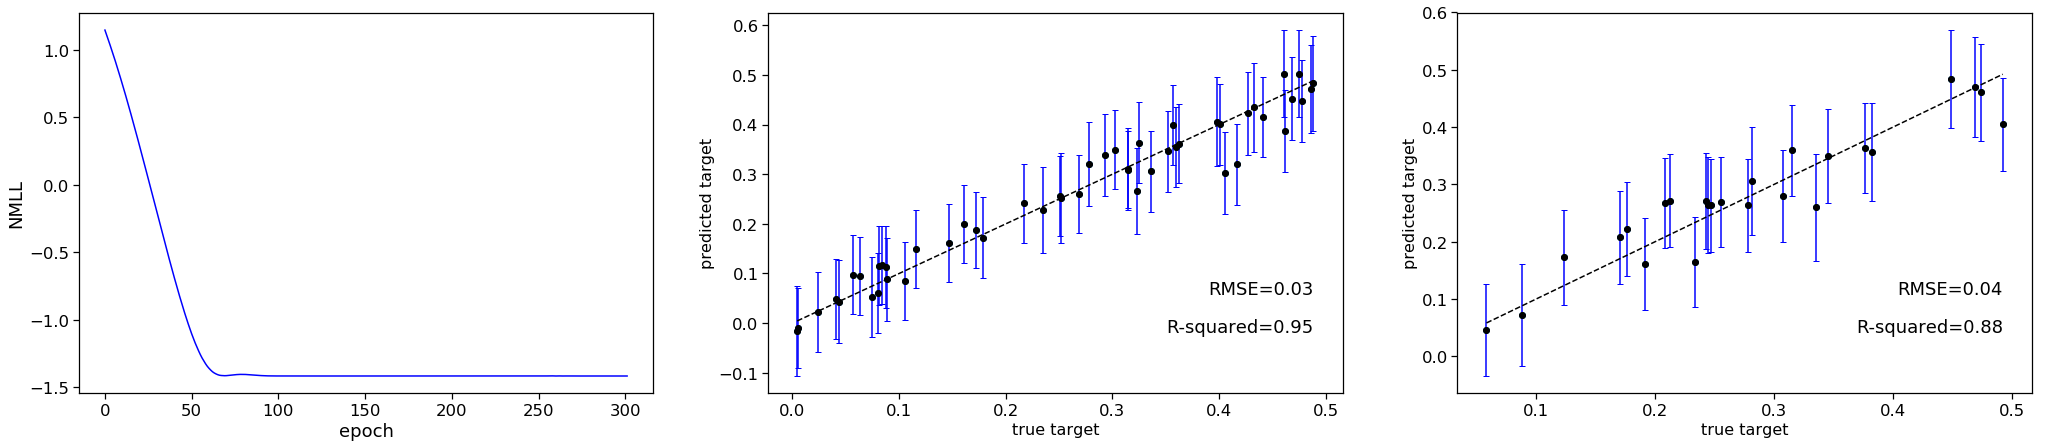

In [47]:
# specs for pathwise expected sig
reload(signature_features)
reload(experiments)
sig_level1 = 4

# specs for signature
sig_level2 = 1

# pathwise expected sig  
expected_pathwise_sig = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug],sig_level1)

features = expected_pathwise_sig

# potentially standard scale the features
scaler = StandardScaler()
to_fit = np.array([features[i] for i in train_indices]).reshape(-1,features.shape[1])
scaler.fit(to_fit)
features = scaler.transform(features.reshape(-1,features.shape[1])).reshape(features.shape)

# compute the signature of the pathwise expected signature
signatures = iisignature.sig(features,sig_level2)


# potentially standard scale the features
scaler = StandardScaler()
to_fit = [signatures[i] for i in train_indices]
scaler.fit(to_fit)
signatures = scaler.transform(signatures)

print('shape of the final features (N_bags, D):', signatures.shape)

# Precompute the Gram matrix
K_precomputed = experiments.precompute_K(signatures)

# Train and Predict
experiments.experiment_precomputed(K_precomputed, y_scaled,train_indices,test_indices,plot=True)

      

# Method: RBF kernel mean embedding

\begin{align*}
K_3(\mu,\nu)=\langle\mathbb{E}_{X\sim\mu}[\Phi_{\mathrm{SE}}(X)],\mathbb{E}_{Y\sim\nu}[\Phi_{\mathrm{SE}}(Y)]\rangle
\end{align*}

shape of the input (N_bags, N_items, D): (75, 15, 398)


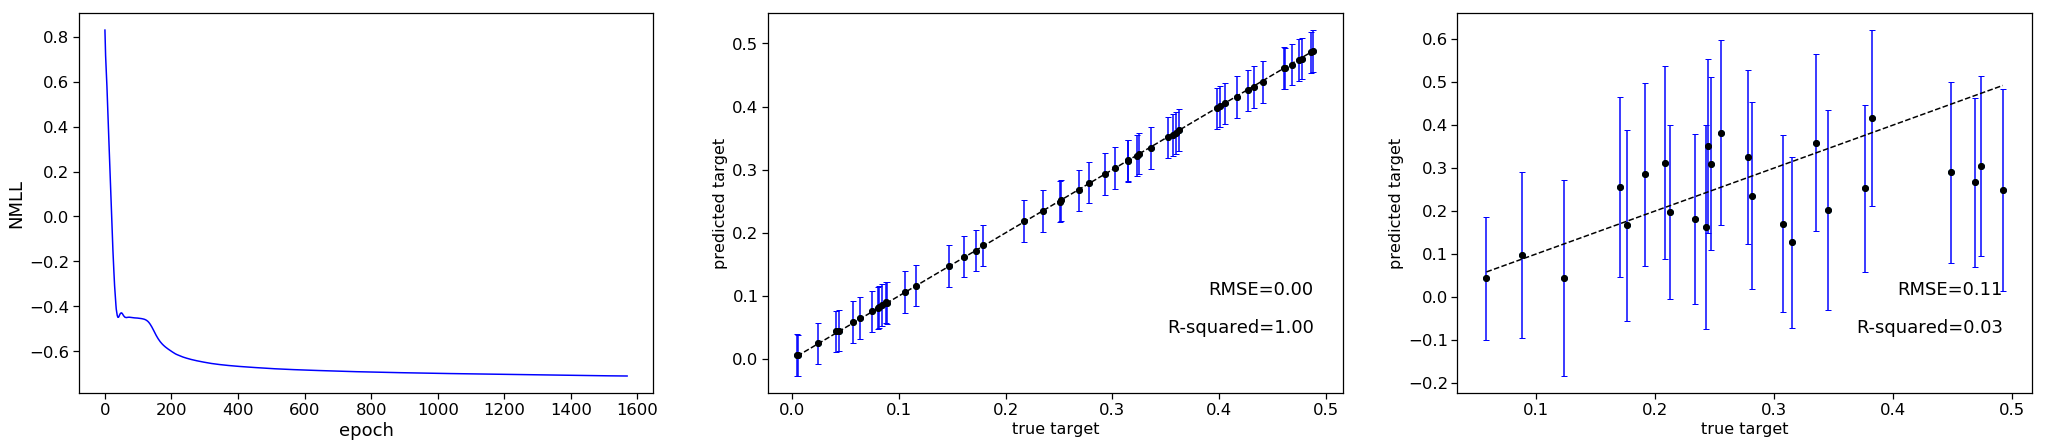

(0.001152200087572528,
 0.9999442624067374,
 0.113858387977872,
 0.025933431703514254,
 array([[0.25566318],
        [0.26684975],
        [0.38244005],
        [0.17090144],
        [0.24862035],
        [0.31016536],
        [0.35093799],
        [0.28550375],
        [0.19758539],
        [0.18066002],
        [0.23579918],
        [0.31223807],
        [0.25254889],
        [0.16696132],
        [0.28962792],
        [0.32642375],
        [0.04317742],
        [0.12683346],
        [0.04393517],
        [0.20254115],
        [0.0977418 ],
        [0.41629907],
        [0.30545231],
        [0.35870485],
        [0.16208709]]))

In [29]:
reload(experiments)
reload(GP_classic)

# We use the same augmented path as used in the signature methods
input_ = X_aug

# but we stack dimensions of the paths
N = np.array(input_).shape[3]
input_ = np.concatenate([np.array(np.array(input_)[:,:,:,k]) for k in range(N)],axis=2)
print('shape of the input (N_bags, N_items, D):', input_.shape)

# Train and predict
a,b,c,experiments.naive_experiment(input_,y_scaled ,train_indices,test_indices,param_init=[5,0,0],plot=True,ARD=True)



# Comments

* The \textit{expected signature} method with a RBF second-level kernel gives poor results in this experiment. I have not checked different hyperparameters initializations for the RBF second-level kernel. The results correspond to a linear kernel (by setting RBF=False), i.e.

\begin{align*}
K_1(\mu,\nu)=\sigma^2\langle\mathbb{E}_{X\sim\mu}[S^{\leq n}(X)],\mathbb{E}_{Y\sim\nu}[S^{\leq n}(Y)]\rangle
\end{align*}


* The \textit{pathwise expected signature} method gives the best results (in this experiment) for a truncation level equal to 1, which is equivalent to the above 

\begin{align*}
K_2(\mu,\nu)=\langle S^{\leq 1}(\gamma^{\mu}), S^{\leq 1}(\gamma^{\nu})\rangle=K_1(\mu,\nu) && \gamma^{\mu}=t\mapsto\mathbb{E}_{X\sim\mu}S^{\leq n}(X|_{0,t})
\end{align*}


